In [1]:
import numpy as np   
np.random.seed(42)   ## so that output would be same
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
#models
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers import Dense
#Evaluation
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score



# data processing 

In [2]:
data = pd.read_csv("diabetes.csv")
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None


In [3]:
data[["Glucose",  "BloodPressure","SkinThickness","Insulin","BMI"]]=data[["Glucose",  "BloodPressure","SkinThickness","Insulin","BMI"]].replace(0,np.nan)

In [4]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   763 non-null    float64
 2   BloodPressure             733 non-null    float64
 3   SkinThickness             541 non-null    float64
 4   Insulin                   394 non-null    float64
 5   BMI                       757 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 54.1 KB
None


In [5]:
l=["Glucose",  "BloodPressure","SkinThickness","Insulin","BMI"]
def median_target(var):   
    temp = data[data[var].notnull()]
    temp = temp[[var, 'Outcome']].groupby(['Outcome'])[[var]].mean().reset_index()
    return temp
for ele in l:
    print(median_target(ele))

   Outcome     Glucose
0        0  110.643863
1        1  142.319549
   Outcome  BloodPressure
0        0      70.877339
1        1      75.321429
   Outcome  SkinThickness
0        0      27.235457
1        1      33.000000
   Outcome     Insulin
0        0  130.287879
1        1  206.846154
   Outcome        BMI
0        0  30.859674
1        1  35.406767


In [7]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    float64
 3   SkinThickness             768 non-null    float64
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 54.1 KB
None


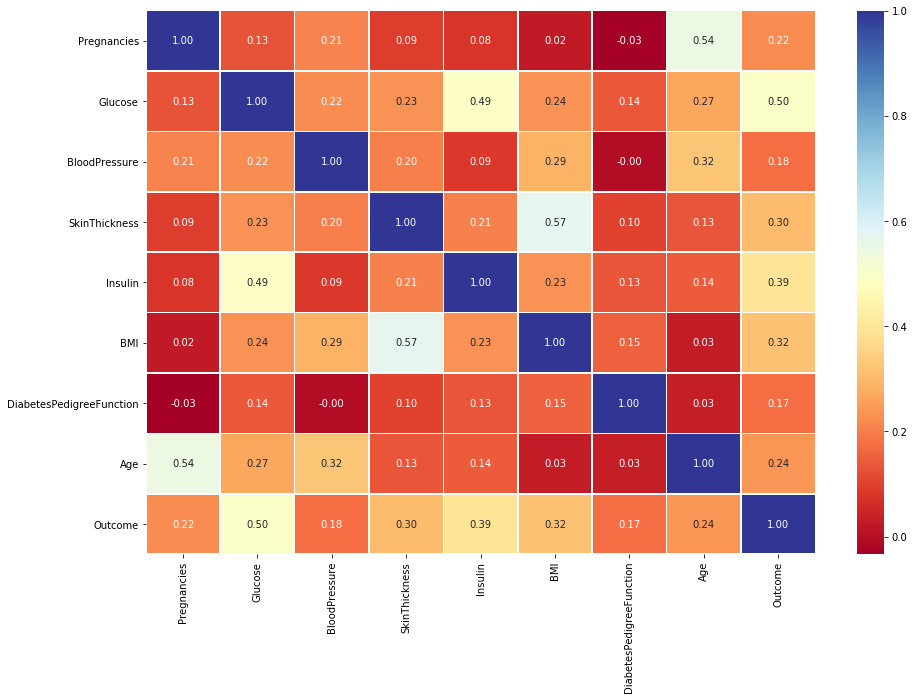

In [8]:
## It shows the correlation(positive,neagative) between different columns(only integer value columns) 
corr_matrix = data.corr()
fig,ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(corr_matrix,annot=True,linewidth=0.5,fmt=".2f",cmap="RdYlBu")

###### Distribution of data set 

In [19]:
data.sample(frac=1)
X = data.drop("Outcome",axis=1)
y = data["Outcome"]
X_train,X_test,y_train,y_test =  train_test_split(X,y,test_size=0.2)


# Models 

In [29]:

log_reg = LogisticRegression(random_state=0)
log_reg.fit(X_train,y_train);

## Evaluating the model
log_reg = log_reg.score(X_test,y_test)

## Build an model (KNN)
knn = KNeighborsClassifier()
knn.fit(X_train,y_train);
## Evaluating the model
knn = knn.score(X_test,y_test)


## Build an model (Random forest classifier)
clfm= RandomForestClassifier()
clfm.fit(X_train,y_train);
y_pred=clfm.predict(X_test)
## Evaluating the model
clf = clfm.score(X_test,y_test)
## Build an model (Support Vector Machine)
svm = SVC()
svm.fit(X_train,y_train)
## Evaluating the model
svm = svm.score(X_test,y_test)


##Build an model(Neural model )
model = Sequential()
model.add(Dense(12, input_dim=8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=200, batch_size=10)
_, nn_acc = model.evaluate(X_test, y_test)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Epoch 1/200
62/62 [==============================] - 0s 676us/step - loss: 6.2113 - accuracy: 0.5831
Epoch 2/200
62/62 [==============================] - 0s 724us/step - loss: 0.6845 - accuracy: 0.5407
Epoch 3/200
62/62 [==============================] - 0s 726us/step - loss: 0.6450 - accuracy: 0.6417
Epoch 4/200
62/62 [==============================] - 0s 708us/step - loss: 0.6096 - accuracy: 0.6515
Epoch 5/200
62/62 [==============================] - 0s 738us/step - loss: 0.5939 - accuracy: 0.6531
Epoch 6/200
62/62 [==============================] - 0s 768us/step - loss: 0.5830 - accuracy: 0.7085
Epoch 7/200
62/62 [==============================] - 0s 778us/step - loss: 0.5774 - accuracy: 0.7052
Epoch 8/200
62/62 [==============================] - 0s 721us/step - loss: 0.5764 - accuracy: 0.7101
Epoch 9/200
62/62 [==============================] - 0s 775us/step - loss: 0.5737 - accuracy: 0.7020
Epoch 10/200
62/62 [==============================] - 0s 965us/step - loss: 0.5670 - accura

62/62 [==============================] - 0s 676us/step - loss: 0.4303 - accuracy: 0.8094
Epoch 82/200
62/62 [==============================] - 0s 547us/step - loss: 0.4304 - accuracy: 0.8111
Epoch 83/200
62/62 [==============================] - 0s 643us/step - loss: 0.4277 - accuracy: 0.8062
Epoch 84/200
62/62 [==============================] - 0s 563us/step - loss: 0.4349 - accuracy: 0.8029
Epoch 85/200
62/62 [==============================] - 0s 547us/step - loss: 0.4290 - accuracy: 0.8078
Epoch 86/200
62/62 [==============================] - 0s 660us/step - loss: 0.4327 - accuracy: 0.8094
Epoch 87/200
62/62 [==============================] - 0s 579us/step - loss: 0.4331 - accuracy: 0.7964
Epoch 88/200
62/62 [==============================] - 0s 1ms/step - loss: 0.4322 - accuracy: 0.8094
Epoch 89/200
62/62 [==============================] - 0s 981us/step - loss: 0.4372 - accuracy: 0.8029
Epoch 90/200
62/62 [==============================] - 0s 1ms/step - loss: 0.4270 - accuracy: 0.81

Epoch 161/200
62/62 [==============================] - 0s 579us/step - loss: 0.3933 - accuracy: 0.8176
Epoch 162/200
62/62 [==============================] - 0s 692us/step - loss: 0.3882 - accuracy: 0.8306
Epoch 163/200
62/62 [==============================] - 0s 643us/step - loss: 0.3874 - accuracy: 0.8290
Epoch 164/200
62/62 [==============================] - 0s 633us/step - loss: 0.3858 - accuracy: 0.8322
Epoch 165/200
62/62 [==============================] - 0s 653us/step - loss: 0.3905 - accuracy: 0.8241
Epoch 166/200
62/62 [==============================] - 0s 633us/step - loss: 0.3887 - accuracy: 0.8355
Epoch 167/200
62/62 [==============================] - 0s 600us/step - loss: 0.3888 - accuracy: 0.8306
Epoch 168/200
62/62 [==============================] - 0s 752us/step - loss: 0.3828 - accuracy: 0.8322
Epoch 169/200
62/62 [==============================] - 0s 949us/step - loss: 0.3957 - accuracy: 0.8208
Epoch 170/200
62/62 [==============================] - 0s 1ms/step - loss

In [28]:
print('Accuracy of Neural network: %.2f' % (nn_acc*100))
print('Accuracy of logistic regression : %.2f' % (log_reg*100))
print('Accuracy of Knn: %.2f' % (knn*100))
print('Accuracy of Random Forest Classifier : %.2f' % (clf*100))
print('Accuracy of SVM : %.2f' % (svm*100))



Accuracy of Neural network: 75.97
Accuracy of logistic regression : 75.32
Accuracy of Knn: 85.71
Accuracy of Random Forest Classifier : 86.36
Accuracy of SVM : 86.36


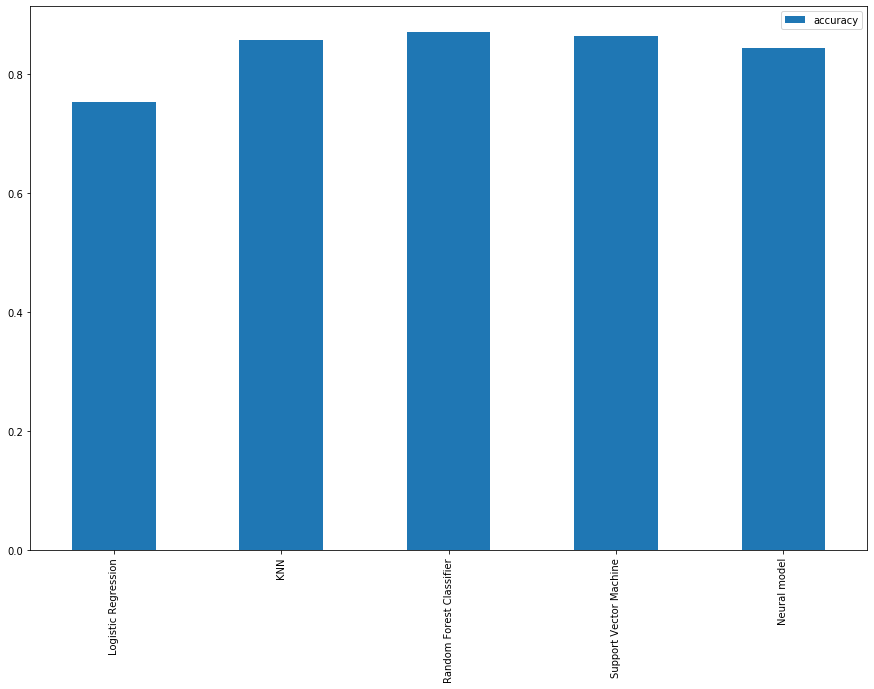

In [22]:
model_compare = pd.DataFrame({"Logistic Regression":log_reg,
"KNN":knn,
"Random Forest Classifier":clf,
"Support Vector Machine":svm,"Neural model":nn_acc},
index=["accuracy"])
model_compare.T.plot.bar(figsize=(15,10));

In [25]:
confusion_matrix(y_test, y_pred)

array([[92,  7],
       [12, 43]], dtype=int64)